In [294]:
from imblearn.ensemble import BalancedRandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import tensorflow as tf
%matplotlib inline

In [295]:
features = pd.read_pickle("train_features.pkl")
labels = pd.read_csv("train_labels.csv",index_col="challenge_oid")
features.index.name = "challenge_oid"
features = features.join(labels)

In [296]:
labels = features["classALeRCE"]
del features["classALeRCE"] 

In [297]:
periodic = ["RRL", "EB", "DSCT", "Ceph", "Periodic-Other"]
stochastic = ["AGN", "QSO", "YSO", "CV/Nova", "LPV", "Blazar"]
transient = ["SNIa", "SNII", "SNIbc"]

In [298]:
maps = {"SNIa":0, "SNII":1, "SNIbc":2, "RRL":3, 
             "EB":4, "DSCT":5, "Ceph":6, "Periodic-Other":7, 
             "AGN":8, "QSO":9, "YSO":10, "CV/Nova":11, "LPV":12, "Blazar":13}

colums = ["SNIa", "SNII", "SNIbc", "RRL", 
             "EB", "DSCT", "Ceph", "Periodic-Other", 
             "AGN", "QSO", "YSO", "CV/Nova", "LPV", "Blazar"]

In [299]:
def map_class(x):
    class_map = {"periodic": periodic, "stochastic": stochastic, "transient": transient}
    for i in class_map:
        if x in class_map[i]:
            return i

In [300]:
new_classes = []
for old_class in labels.values:
    new_classes.append(map_class(old_class))

In [301]:
new_classes_low = []
for old_class in labels.values:
    new_classes_low.append(maps[old_class])

In [302]:
root_le = LabelEncoder()
new_classes_encoded = root_le.fit_transform(new_classes)

In [303]:
low_le = LabelEncoder()
new_classes_low = low_le.fit_transform(new_classes_low)

In [304]:
minmax = MinMaxScaler()
minmax.fit(features)
scaled_features = minmax.transform(features)
scaled_features = scaled_features+1
scaled_features = np.nan_to_num(scaled_features)-1 

In [321]:
inputs = tf.keras.layers.Input(len(features.columns)) 

layer1 = tf.keras.layers.Dense(128,activation="relu")(inputs)
layer1 = tf.keras.layers.Dropout(0.2)(layer1)
layer2 = tf.keras.layers.Dense(64,activation="relu")(layer1)
layer2 = tf.keras.layers.Dropout(0.2)(layer2)
layer3 = tf.keras.layers.Dense(32,activation="relu")(layer2)
layer3 = tf.keras.layers.Dropout(0.2)(layer3)

out_root = tf.keras.layers.Dense(3,activation="softmax")(layer3)
l1 = tf.keras.layers.Dense(16,activation="relu")(layer3)
outputs = tf.keras.layers.Dense(14,activation="softmax")(l1)

model = tf.keras.models.Model(inputs=inputs, outputs=[out_root,outputs])

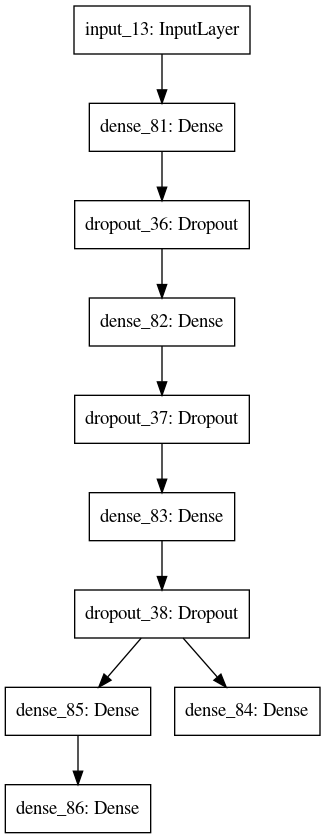

In [322]:
tf.keras.utils.plot_model(model)

In [323]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="loss",min_delta=1e-5, patience=5),tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [324]:
ros = RandomOverSampler(random_state=0)
tmp_features = scaled_features.copy()
tmp_features = np.hstack([scaled_features, np.arange(len(tmp_features)).reshape((-1,1))])
X_resampled, y_resampled_low = ros.fit_resample(tmp_features, new_classes_low)

X_resampled_index = X_resampled[:,-1].astype(int)
X_resampled_features = X_resampled[:,:-1]
y_resampled = new_classes_encoded[X_resampled_index]

In [330]:
def loss(y_true,y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true,y_pred) + tf.keras.backend.mean(tf.keras.backend.sum(y_pred,axis=1))

In [ ]:
model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
model.fit(X_resampled_features,[tf.keras.utils.to_categorical(y_resampled), 
                                tf.keras.utils.to_categorical(y_resampled_low)], epochs=100, callbacks=callbacks)

Train on 159250 samples
Epoch 1/100
159250/159250 [==============================] - 9s 59us/sample - loss: 2.8847 - dense_84_loss: 1.1243 - dense_86_loss: 1.7604 - dense_84_accuracy: 0.9525 - dense_86_accuracy: 0.7198
Epoch 2/100
159250/159250 [==============================] - 9s 57us/sample - loss: 2.8513 - dense_84_loss: 1.1181 - dense_86_loss: 1.7332 - dense_84_accuracy: 0.9555 - dense_86_accuracy: 0.7319
Epoch 3/100
159250/159250 [==============================] - 10s 61us/sample - loss: 2.8179 - dense_84_loss: 1.1134 - dense_86_loss: 1.7045 - dense_84_accuracy: 0.9575 - dense_86_accuracy: 0.7443
Epoch 4/100
159250/159250 [==============================] - 11s 68us/sample - loss: 2.7984 - dense_84_loss: 1.1113 - dense_86_loss: 1.6871 - dense_84_accuracy: 0.9590 - dense_86_accuracy: 0.7501
Epoch 5/100
159250/159250 [==============================] - 11s 68us/sample - loss: 2.7716 - dense_84_loss: 1.1067 - dense_86_loss: 1.6649 - dense_84_accuracy: 0.9605 - dense_86_accuracy: 0.757

In [311]:
test_features = pd.read_pickle("test_features.pkl")

In [312]:
scaled_test_features = minmax.transform(test_features)
scaled_test_features = scaled_test_features+1
scaled_test_features = np.nan_to_num(scaled_test_features)-1 

In [313]:
_,probs = model.predict(scaled_test_features)

In [314]:
probs = pd.DataFrame(probs, columns=colums)

In [315]:
probs["Outlier"] = 1/(len(colums)+1)

In [316]:
probs.index = test_features.index

In [317]:
probs.index.name = "challenge_oid"

In [318]:
probs.to_csv("hierarchical_mlp_v2.csv")

In [319]:
_,old_probs = model.predict(scaled_features)
old_probs = pd.DataFrame(old_probs, columns=colums)
old_probs["Outlier"] = 1/(len(colums)+1)
old_probs.index = features.index
old_probs.index.name = "challenge_oid"

In [320]:
classes = labels.classALeRCE
for c in classes.unique():
    fig, ax = plt.subplots(1,1,figsize=(12,4))
    for cj in classes.unique():
        sns.distplot(old_probs[classes == c][cj],ax=ax,label=cj)
    ax.set_xlim((0,1))
    ax.set_xlabel(c)
    ax.legend()
    plt.show()

AttributeError: 'Series' object has no attribute 'classALeRCE'

In [ ]:
pred_class = old_probs.idxmax(axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(labels.loc[pred_class.index].values, pred_class.values)

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plt.figure(figsize = (14, 10))
plot_confusion_matrix(cm, old_probs.columns,normalize=True)